# Data exploration

In [7]:
import csv
import h5py
import json

import cv2
import math
import numpy as np

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pylab
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.image as mpimg

import seaborn as sns; 
sns.set(color_codes=True)

matplotlib.pylab.rcParams['figure.figsize'] = (18, 12)
matplotlib.pylab.rcParams['agg.path.chunksize'] = 10000

In [1]:
# Load simulation data.
filename = './data/5/dataset.npz'
data = np.load(filename)
images = data['images']

# Pre-process images.
images = images.astype(np.float32) / 255.
images = 2. * images - 1.

angle = data['angle']

NameError: name 'np' is not defined

In [460]:
# Load CSV file
filename = './data/5/driving_log.csv'
filename = './data/50Hz_driving_log.csv'
with open(filename, 'r') as f:
    creader = csv.reader(f)
    csv_list = list(creader)
    
    # Read angle.
    angle = np.array([float(a[3]) for a in csv_list], dtype=np.float32)
    
    # Speed: convert to m/s.
    speed = np.array([float(a[6]) for a in csv_list], dtype=np.float32)
    speed = speed * 1.609344 / 3.6
    
    # Time difference
    dt_array = np.zeros_like(angle)
    for i in range(len(csv_list)-1):
        p0 = csv_list[i][0][:-4].split("_")
        p1 = csv_list[i+1][0][:-4].split("_")
        
        t0 = float(p0[-1])* 0.001 + float(p0[-2]) + float(p0[-3]) * 60. + float(p0[-4]) * 3600.
        t1 = float(p1[-1])* 0.001 + float(p1[-2]) + float(p1[-3]) * 60. + float(p1[-4]) * 3600.
        
        dt_array[i] = t1 - t0
        

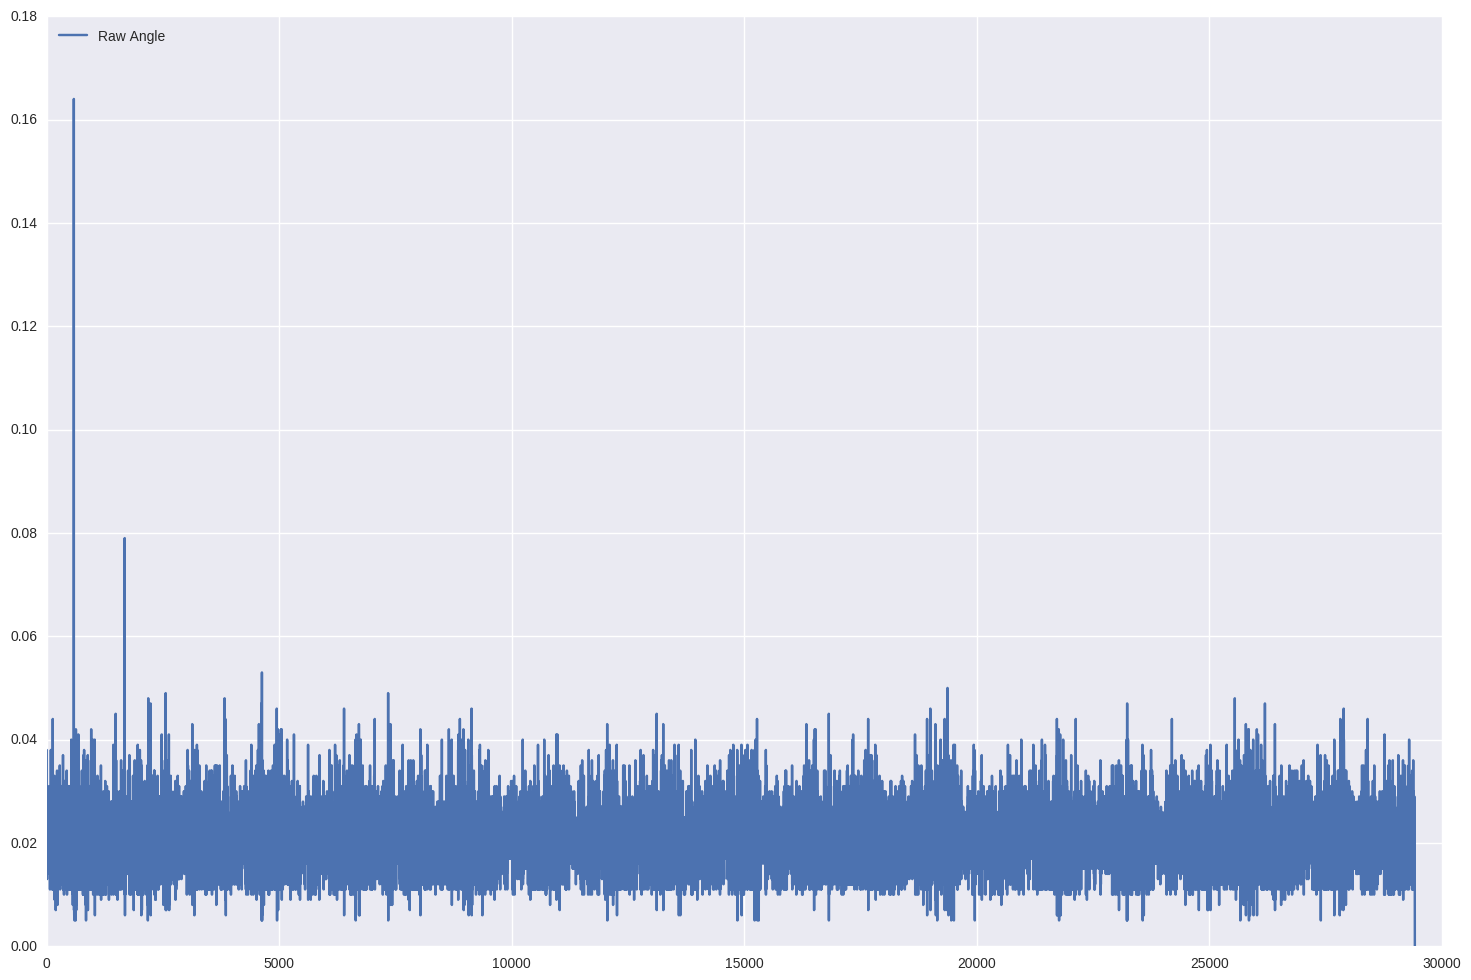

In [461]:
plt.plot(dt_array, label='Raw Angle')
# plt.plot(data['angle_sth16'], label='Post-smooth16')
# plt.plot(data['angle_rsth16'], label='Pre-smooth16')
# plt.plot(data['angle_pre6'], label='Pre-avg6')

plt.legend(loc='upper left')
plt.show()

In [462]:
def sinc(alpha):
    y = np.ones_like(alpha)
    mask = alpha != 0.0 
    y[mask] = np.sin(alpha[mask]) / alpha[mask]
    return y

def cosc(alpha):
    y = np.zeros_like(alpha)
    mask = alpha != 0.0 
    y[mask] = (1. - np.cos(alpha[mask])) / alpha[mask]
    return y


In [463]:
# Constant: frequency, speed and car length
dt = 0.1
dt = 0.02

length = 5.85

# speed = 48.28032 * 1000 / 3600
# speed = 48 * 1000 / 3600

# Rotation radius
# radius = length / np.sin(angle)
alpha = speed * dt_array / length * np.sin(angle)

# dx displacement vectors.
dx = np.zeros(shape=(len(angle), 2), dtype=np.float32)
dx[:, 0] = speed * dt_array * cosc(alpha)
dx[:, 1] = speed * dt_array * sinc(alpha)
# dx[:, 2] = 1.0

# Affine transformation.
rot_trans = np.zeros(shape=(len(angle), 2, 2), dtype=np.float32)
rot_trans[:, 0, 0] = np.cos(alpha)
rot_trans[:, 1, 1] = np.cos(alpha)
rot_trans[:, 0, 1] = np.sin(alpha)
rot_trans[:, 1, 0] = -np.sin(alpha)
# aff_trans[:, :, 2] = dx


In [464]:
# Compute position vector of the car.
x = np.zeros(shape=(len(angle)+1, 2), dtype=np.float32)
v1 = np.array([1., 0.], dtype=np.float32)
v2 = np.array([0., 1.], dtype=np.float32)

tr = np.identity(2, dtype=np.float32)

for i in range(len(angle)):
    v1 = np.matmul(rot_trans[i], v1)
    v2 = np.matmul(rot_trans[i], v2)
    
    x[i+1] = x[i] 
    x[i+1] += v1 * dx[i, 0]
    x[i+1] += v2 * dx[i, 1]

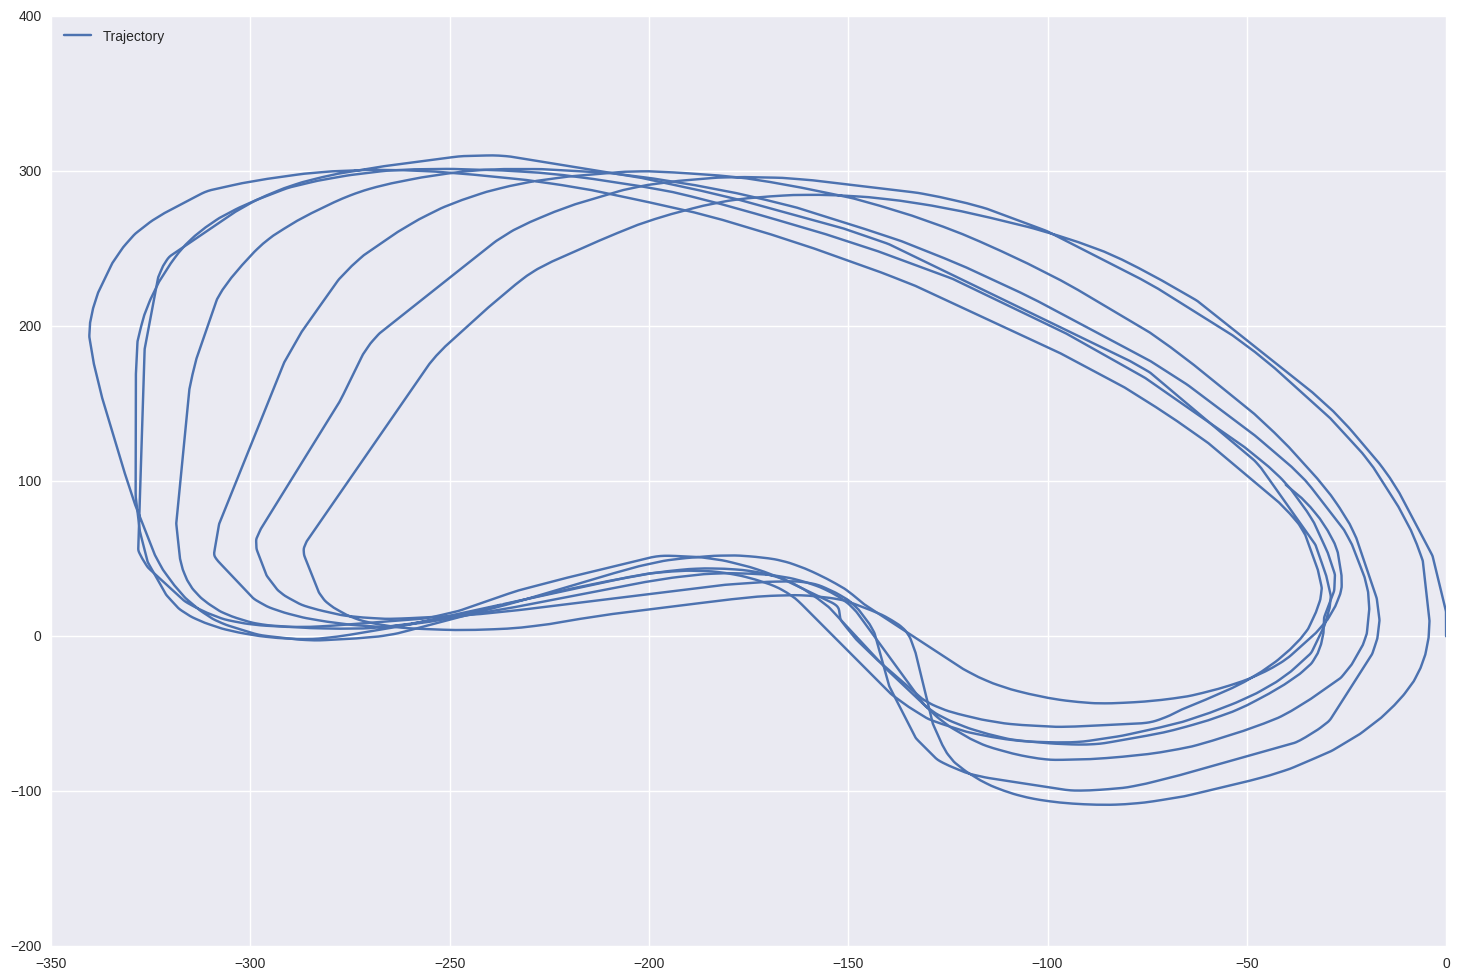

In [465]:
nb = 100000

plt.plot(x[:nb, 0], x[:nb, 1], label='Trajectory')
# plt.plot(data['angle_sth16'], label='Post-smooth16')
# plt.plot(data['angle_rsth16'], label='Pre-smooth16')
# plt.plot(data['angle_pre6'], label='Pre-avg6')

plt.legend(loc='upper left')
plt.show()